# Nightlights Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# re-read in file
filename = 'data/All_Villages_All_Years_Export_20230925_Medians.csv'
df = pd.read_csv(filename)
df.columns

Index(['system:index', 'bigBuffer2014', 'bigBuffer2015', 'bigBuffer2016',
       'bigBuffer2017', 'bigBuffer2018', 'bigBuffer2019', 'bigBuffer2020',
       'bigBuffer2021', 'bigBuffer2022', 'buffer2014', 'buffer2015',
       'buffer2016', 'buffer2017', 'buffer2018', 'buffer2019', 'buffer2020',
       'buffer2021', 'buffer2022', 'country', 'customers', 'date_commissioned',
       'developer', 'site_name', 'source', 'status', 'system:time_start',
       'village2014', 'village2015', 'village2016', 'village2017',
       'village2018', 'village2019', 'village2020', 'village2021',
       'village2022', '.geo'],
      dtype='object')

In [5]:
# keep only sites with CrossBoundary as the sourece
df = df[df['source'] == 'CBIL']
df.shape

(206, 37)

In [6]:
# pull in sites from cbil
cbil_sites = pd.read_csv('data/site_data.csv')
cbil_sites.head()

,site_id_odyssey,site,developer,country,metadata.project.latitude,metadata.project.longitude,metadata.project.status,data_source,metadata.project.cod
0,bc9f90e8-d231-40ba-9e39-07ad051780da,179,"Powerhive, Inc.",Kenya,-0.639832,34.809937,OPERATING,OES,2022-01-01 00:00:00+00:00
1,bcee85a6-8d8e-41c8-b857-d9454d69494c,128 A,"Powerhive, Inc.",Kenya,-0.869752,34.998479,OPERATING,OES,2022-01-01 00:00:00+00:00
2,16db27a5-081f-4df8-9911-650c418f1d09,Manowa,WindGen Power USA Inc. (PowerGen),Sierra Leone,7.897010,-10.840820,OPERATING,OES,2021-12-31 00:00:00+00:00
3,8b5e11ff-ee6d-4157-a46c-03f367406d3f,Kirwa site C,"Powerhive, Inc.",Kenya,-0.891742,34.764067,OPERATING,OES,2021-09-10 00:00:00+00:00
4,99abfbcf-e9b5-44ea-8ba6-4e51dbb3d013,Faradje,Nuru S.A.R.L,DR Congo,3.731911,29.707706,OPERATING,OES,2021-07-01 00:00:00+00:00


In [7]:

# check for unique sites in cbil_sites
cbil_sites['site'].nunique()

# return any non-unique sites
cbil_sites[cbil_sites.duplicated(['site'], keep=False)]

# look at sites with WindGen Power USA Inc. (PowerGen) as the developer
cbil_sites[cbil_sites['developer'] == 'WindGen Power USA Inc. (PowerGen)']

# look at sites with Crossboundary Energy Access as the developer
cbil_sites[cbil_sites['developer'] == 'Crossboundary Energy Access']

# filter these out since they are duplicates of PowerGen sites
cbil_sites = cbil_sites[cbil_sites['developer'] != 'Crossboundary Energy Access']

# now pull in the commissioning dates by site name 
df['date_commissioned'] = df['site_name'].map(cbil_sites.set_index('site')['metadata.project.cod'])

# check for nulls in date_commissioned
df['date_commissioned'].isnull().sum()

# filter out nulls
df = df[df['date_commissioned'].notnull()]

## Analyze Grids by Year Commissioned

In [9]:
# extract the year from the date_commissioned column

# convert date_commissioned to datetime
df["date_commissioned"] = pd.to_datetime(df["date_commissioned"])

# create a new column called year
df["year"] = df["date_commissioned"].dt.year

# convert year to string
df["year"] = df["year"].astype(str)

# print the various years of commissioning
df['year'].unique()


array(['2018', '2014', '2015', '2019', '2020', '2021', '2017', '2016',
       '2022'], dtype=object)

In [27]:
# plot the median nightlights by year
df.T.plot(legend=False)


TypeError: no numeric data to plot

In [10]:
# create dataframes to store results

# create a series from -8 to 8
r = range(-8, 9)
s = pd.Series(r)
# cols = ['site_name'].append(s)

# create a new df with columns village, year
df_vil = pd.DataFrame(columns=s)
df_buf = pd.DataFrame(columns=s)
df_bigBuf = pd.DataFrame(columns=s)


In [11]:
# define a function to get the column value of a dataframe

# if df.columns.get_loc() is an error, return a 0
# otherwise, return the column index
def get_col_value(row, col_name):
    try:
        return row[col_name]
    except KeyError:
        return None

In [12]:
# extract values into new dfs

# loop over rows in df
for index, row in df.iterrows():
    # village = row['site_name']
    # source = row['source']
    # status = row['status']
    # country = row['country']
    year = int(row['year'])
    # find the column that contains this year
    vilCol = 'village' + str(year)
    bufCol = 'buffer' + str(year)
    bigBufCol = 'bigBuffer' + str(year)
 
    # loop over the years to pull out the values and add to df_bigBuf
    for col in r:
        # find the column that contains this year
        vilCol = 'village' + str(year + col)
        bufCol = 'buffer' + str(year + col)
        bigBufCol = 'bigBuffer' + str(year + col)
        
        # return the value of the column index vilColIndex
        vilVal = get_col_value(row, vilCol)
        bufVal = get_col_value(row, bufCol)
        bigBufVal = get_col_value(row, bigBufCol)
        
        # add the values to the df_bigBuf
        df_vil.loc[index, col] = bigBufVal
        df_buf.loc[index, col] = bufVal
        df_bigBuf.loc[index, col] = vilVal

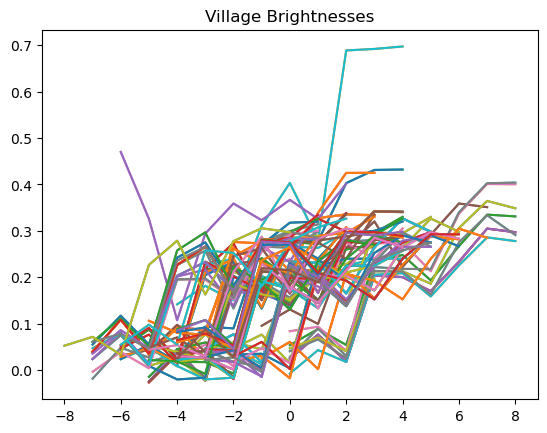

<AxesSubplot:title={'center':'Normalized Village Brightnesses'}>

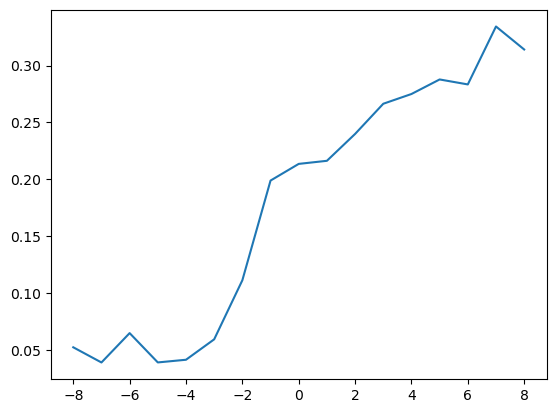

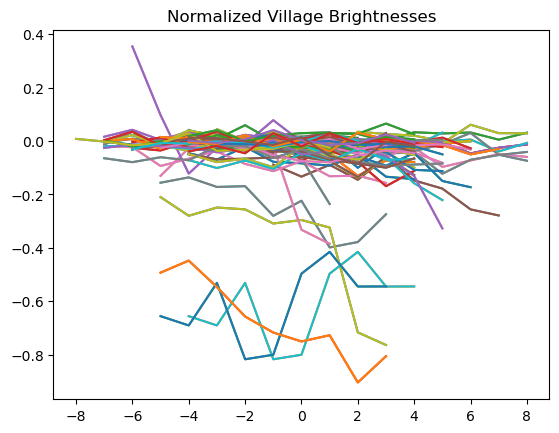

In [31]:
# plot the village brightnesses as a function of the column headers
df_vil.T.plot(legend=False, title='Village Brightnesses')
plt.show()

# plot the median village brightnesses as a function of the column headers
df_vil.median().plot()

df_vil_norm = df_vil - df_bigBuf

# filter out values below -5
df_vil_norm[df_vil_norm < -5] = 0
df_vil_norm.T.plot(legend=False, title='Normalized Village Brightnesses')



<AxesSubplot:>

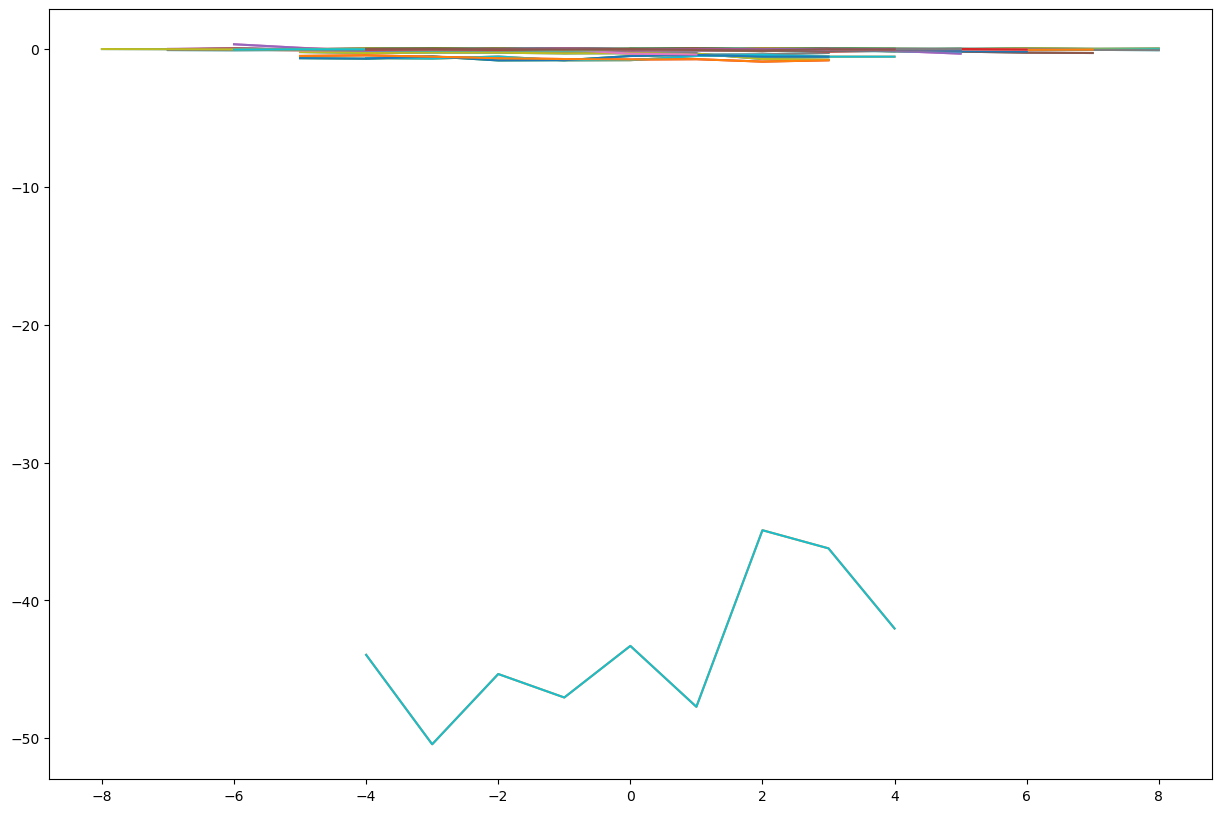

In [17]:
# normalize df_vil with df_bigBuf
# try to get the relative difference in brightness of the village compared to its surrounding

df_vil_norm_1 = df_vil - df_bigBuf

# divide the value of column '0' from all values in each row
# df_vil_norm_1 = df_vil_norm_1.div(df_vil_norm_1[0], axis=0) - 1

# I divided first in the original analysis, then subtracted year 0
# here I'm subtracting to get the relative difference in brightness of the village compared to its surrounding
# instead of the proportional difference of the village relative to its surrounding

# calculate the mean of each column
# df_vil_norm_1_mean = df_vil_norm_1.mean(axis=0)
# df_vil_norm_1_med = df_vil_norm_1.median(axis=0)
# df_vil_norm_1_std = df_vil_norm_1.std(axis=0)

# plot s versus df_vil_norm_med
# plt.plot(s, df_vil_norm_1_med, 'o')

# plt.plot(s, df_vil_norm_1_mean, 'o')

# plot each village by year
df_vil_norm_1.T.plot(legend=False, figsize=(15,10))


In [14]:
# normalize df_vil with df_bigBuf
# try to get the relative difference in brightness of the village by dividing compared to its surrounding

df_vil_norm_2 = df_vil / df_bigBuf

# subtract the value of column '0' from all values in each row
df_vil_norm_2 = df_vil_norm_2.sub(df_vil_norm_2[0], axis=0)

# I divided first in the original analysis, then subtracted year 0
# here I'm subtracting to get the relative difference in brightness of the village compared to its surrounding
# instead of the proportional difference of the village relative to its surrounding

# calculate the mean of each column
df_vil_norm_2_mean = df_vil_norm_2.mean(axis=0)
df_vil_norm_2_med = df_vil_norm_2.median(axis=0)
df_vil_norm_2_std = df_vil_norm_2.std(axis=0)

# plot s versus df_vil_norm_med
plt.plot(s, df_vil_norm_2_med, 'o')
# plt.plot(s, df_vil_norm_2_mean, 'o')

# plot all of the values in df_vil_norm_2
# for index, row in df_vil_norm_2.iterrows():
#     plt.plot(s, row, 'o')


ZeroDivisionError: float division by zero

In [ ]:
############################################################################################################

In [15]:
# for data without a year, just extract the brightness values into separate dfs
# create a series from -8 to 8)
yr = range(2014, 2023)
syr = pd.Series(yr)
# cols = ['site_name'].append(s)

# create a new df with columns village, year
df_vil_year = pd.DataFrame(columns=syr)
df_buf_year = pd.DataFrame(columns=syr)
df_bigBuf_year = pd.DataFrame(columns=syr)

# define a function to get the column value of a dataframe

# if df.columns.get_loc() is an error, return a 0
# otherwise, return the column index
def get_col_value(row, col_name):
    try:
        return row[col_name]
    except KeyError:
        return None


# loop over rows in df
for index, row in df.iterrows():
   
    # loop over the years to pull out the values and add to df_bigBuf
    for year in yr:
        # find the column that contains this year
        vilCol = 'village' + str(year)
        bufCol = 'buffer' + str(year)
        bigBufCol = 'bigBuffer' + str(year)
        
        # return the value of the column index vilColIndex
        vilVal = get_col_value(row, vilCol)
        bufVal = get_col_value(row, bufCol)
        bigBufVal = get_col_value(row, bigBufCol)
        
        # add the values to the df_bigBuf
        df_vil_year.loc[index, year] = bigBufVal
        df_buf_year.loc[index, year] = bufVal
        df_bigBuf_year.loc[index, year] = vilVal

<AxesSubplot:>

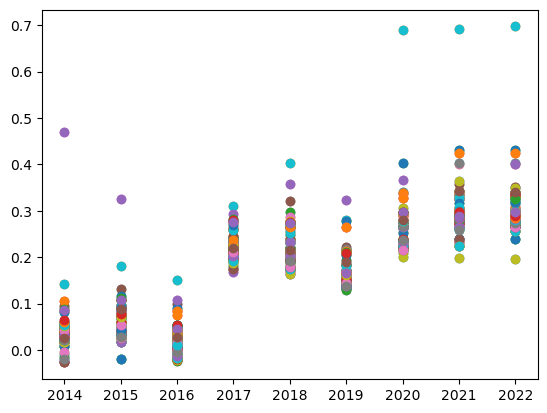

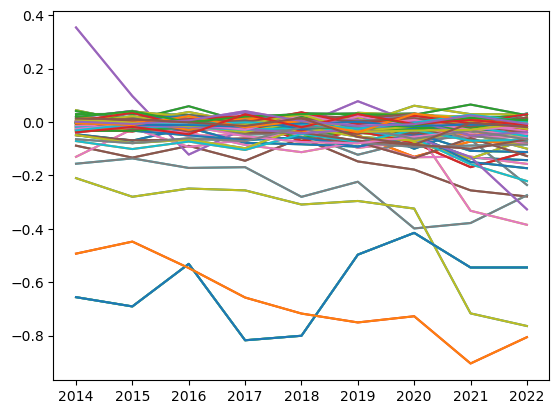

In [28]:
# inspect df_vil_year
# print(df_vil_year.head())
# print(df_vil_year)

# normalize df_vil with df_bigBuf
# try to get the relative difference in brightness of the village compared to its surrounding

df_vil_year_norm = df_vil_year - df_bigBuf_year
# print(df_vil_year_norm_1.head())

# I divided first in the original analysis, then subtracted year 0
# here I'm subtracting to get the relative difference in brightness of the village compared to its surrounding
# instead of the proportional difference of the village relative to its surrounding

# calculate the mean of each column
df_vil_year_mean = df_vil_year.mean(axis=0)
df_vil_year_med = df_vil_year.median(axis=0)
df_vil_year_std = df_vil_year.std(axis=0)

df_vil_year_norm_mean = df_vil_year_norm.mean(axis=0)
df_vil_year_norm_med = df_vil_year_norm.median(axis=0)
df_vil_year_norm_std = df_vil_year_norm.std(axis=0)


# delete any rows with values less than -20
df_vil_year_norm = df_vil_year_norm[df_vil_year_norm > -10]
df_buf_year = df_buf_year[df_buf_year < 10]
df_bigBuf_year = df_bigBuf_year[df_bigBuf_year < 10]

# # plot all of the values in df_vil_year
for index, row in df_vil_year.iterrows():
    plt.plot(yr, row, 'o')

# plot s versus df_vil_norm_med
# plt.plot(syr, df_vil_year_norm_med, 'o')

# create a line plot of the values in df_vil_year_norm with one line for each row with no legend
df_vil_year_norm.T.plot.line(legend=False)

In [14]:
## plotly code from Charlie

average = round(horizontal_bar["Average Kg per Day"].mean(),2)

print("The average number of kg milled per day is :" , average)

# Order based on Volumne

horizontal_bar = horizontal_bar.sort_values(by="Average Kg per Day", ascending=True)

fig = px.bar(horizontal_bar, x = "Name", y = "Average Kg per Day", title = "Average maize milled Per Day by Operator [Kg]")

# Remove yaxes labels

fig.update_xaxes(showticklabels=False)

fig.update_xaxes(title_text="Operator")

# fit average to the graph

fig.add_shape(type="line", y0=horizontal_bar["Average Kg per Day"].mean(), x0=-1, y1=horizontal_bar["Average Kg per Day"].mean(), x1=20, line=dict(color="Red", width=3, dash="dash"))

# Add text stating the average

fig.add_annotation(x=5, y=horizontal_bar["Average Kg per Day"].mean(), text=f"Average kg milled per day is: {average}", showarrow=True, arrowhead=1)

fig.show()

NameError: name 'horizontal_bar' is not defined

In [ ]:
# plotly code #2
""" Plotly templates, graph and text color palettes
    The template can be set by running the following 
    There are two different palettes:
        - 'text_palette' includes the five main CB-style colors for text
        - 'graphs_palette' color scales used for graphs (blue, gray, red, green)
"""

import plotly.graph_objs as go
import plotly.io as pio
from sys import platform as _platform

graphs_palette = {
    "blue_1": "rgb(52, 58, 100)",
    "blue_2": "rgb(51, 58, 135)",
    "blue_3": "rgb(157, 177, 208)",
    "blue_4": "rgb(195, 207, 226)",
    "gray_1": "rgb(0, 0, 0)",
    "gray_2": "rgb(128, 128, 128)",
    "gray_3": "rgb(150, 150, 150)",
    "gray_4": "rgb(192, 192, 192)",
    "red_1": "rgb(232, 28, 0)",
    "red_2": "rgb(195, 10, 61)",
    "red_3": "rgb(250, 134, 148)",
    "red_4": "rgb(255, 193, 193)",
    "green_1": "rgb(152, 219, 212)",
    "green_2": "rgb(176, 235, 229)",
    "green_3": "rgb(205, 254, 243)",
    "green_4": "rgb(247, 255, 247)",
}

# Experimenting with other colours
graphs_palette = {
    "light_green": "rgb(148, 222, 139)",
    "light_pastel_purple": "rgb(177, 156, 217)",
    "lavender_pink": "rgb(244, 168, 207)",
    "pastel_yellow": "rgb(253, 253, 150)",
    "celadon": "rgb(182, 231, 185)"
}


# Turn this into a graphs_palette
graphs_palette = {
    "cb_magenta": "rgb(196, 40, 90)",
    "cb_yellow": "rgb(255, 192, 0)",
    "cb_lightblue": "rgb(195, 207, 225)",
    "cb_baseblue": "rgb(52, 58, 100)",
    "cb_charcoal": "rgb(105, 105, 105)"
}

text_palette = {
    "header_blue": "rgb(52,58,100)",
    "gray_main": "rgb(105,105,105)",
    "light_gray": "rgb(191,191,191)",
    "yellow": "rgb(255,192,0)",
    "magenta": "rgb(196,40,90)",
    "Electric Blue": "rgb(130, 240, 244)",
    "Blue Jeans" : "rgb(91, 188, 240)"
}


if _platform == "darwin":
    text_font = "Gill Sans"
else:
    text_font = "Gill Sans MT"


def use_template():
    """Sets CB style template for the for the notebook."""
    fig = go.Figure(
        layout=dict(
            title="Figure Title",
            font=dict(size=14, family=text_font, color=text_palette["gray_main"]),
            showlegend=True,
            plot_bgcolor="white",
            colorway=[
                # graphs_palette[x] for x in ["light_green", "light_pastel_purple", "lavender_pink", "pastel_yellow", "celadon", "Electric Blue", "Blue Jeans"]
                graphs_palette[x] for x in ["cb_baseblue",  "cb_lightblue", "cb_magenta", "cb_yellow", "cb_charcoal"]
            ],  # Can we do better?
        )
    )

    fig.update_xaxes(
        showline=True, linewidth=1, linecolor=text_palette["gray_main"], title="X Axis"
    )
    fig.update_yaxes(
        showline=True,
        linewidth=1,
        linecolor=text_palette["gray_main"],
        title="Y Axis",
        showticklabels=True,
        ticks="outside",
        tickwidth=1,
        tickcolor=text_palette["gray_main"],
    )
    templated_fig = pio.to_templated(fig)

    pio.templates["cb_graph"] = templated_fig.layout.template

    pio.templates.default = "cb_graph"


# Execute when imported: this registers the above code as the default template
use_template()


In [ ]:
# sites

# Kalenge -- dying
# Kalya -- growing this year
# Leshata -- also dying this year
# Itaswi -- dying
# Kasalazi -- awesome rise until COVID